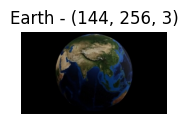

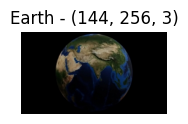

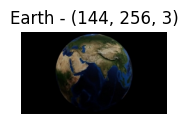

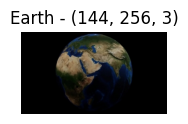

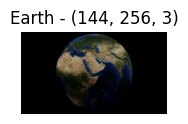

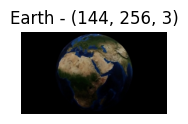

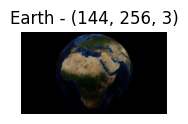

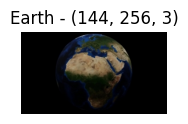

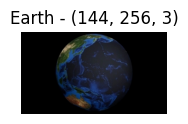

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread

train_dir = './Fleurs/train'
val_dir = './Fleurs/test'

for i in range(9):
    plt.subplot(3, 3, i + 1)
    images = tf.io.gfile.listdir(train_dir + '/' + 'Earth')
    image = imread(train_dir + '/' + 'Earth' + '/' + images[i])
    plt.imshow(image)
    plt.title('Earth' + ' - ' + str(image.shape))
    plt.axis('off')
    plt.show()

In [2]:
# On prend celui qui a le moins d'images pour équilibrer les classes
fleurs = dict()
for fleur in tf.io.gfile.listdir(train_dir):
    fleurs[fleur] = len(tf.io.gfile.listdir(train_dir + '/' + fleur))
print(fleurs)   
print(min(fleurs.values()))

{'Earth': 73, 'Jupiter': 73, 'MakeMake': 73, 'Mars': 73, 'Mercury': 73, 'Moon': 73, 'Neptune': 73, 'Pluto': 73, 'Saturn': 73, 'Uranus': 73, 'Venus': 73}
73


In [3]:
# Chaque classe doit avoir le même nombre d'images, on va donc supprimer les images en trop
min_images = min(fleurs.values())

for fleur in tf.io.gfile.listdir(train_dir):
    images = tf.io.gfile.listdir(train_dir + '/' + fleur)
    for image in images[min_images:]:
        tf.io.gfile.remove(train_dir + '/' + fleur + '/' + image)
        print(len(tf.io.gfile.listdir(train_dir + '/' + fleur)))

In [4]:
# On va mettre la moitié des images de chaque classe dans le dossier test
if len(tf.io.gfile.listdir(val_dir)) == 0:
    tf.io.gfile.rmtree(val_dir)
    tf.io.gfile.makedirs(val_dir)
    
    for fleur in tf.io.gfile.listdir(train_dir):
        i = len(tf.io.gfile.listdir(train_dir + '/' + fleur))
        tf.io.gfile.makedirs(val_dir + '/' + fleur)
        images = tf.io.gfile.listdir(train_dir + '/' + fleur)
        y = 0
        for image in images:
            if y <= i/2:
                tf.io.gfile.copy(train_dir + '/' + fleur + '/' + image, val_dir + '/' + fleur + '/' + image)
                tf.io.gfile.remove(train_dir + '/' + fleur + '/' + image)
                y+= 1

In [5]:
# On vérifie que tout est bon
len(tf.io.gfile.listdir(train_dir))

print("Sur le dossier train :")

for fleur in tf.io.gfile.listdir(train_dir):
    print(f"{fleur} - {len(tf.io.gfile.listdir(train_dir + '/' + fleur))} images")
    
print("\nSur le dossier test :")

for fleur in tf.io.gfile.listdir(val_dir):
    print(f"{fleur} - {len(tf.io.gfile.listdir(val_dir + '/' + fleur))} images")

Sur le dossier train :
Earth - 73 images
Jupiter - 73 images
MakeMake - 73 images
Mars - 73 images
Mercury - 73 images
Moon - 73 images
Neptune - 73 images
Pluto - 73 images
Saturn - 73 images
Uranus - 73 images
Venus - 73 images

Sur le dossier test :
Earth - 75 images
Jupiter - 75 images
MakeMake - 75 images
Mars - 75 images
Mercury - 75 images
Moon - 75 images
Neptune - 75 images
Pluto - 75 images
Saturn - 75 images
Uranus - 75 images
Venus - 75 images


In [6]:
# On enregistre les images dans des générateurs
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    seed = 42
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    seed = 42
)

Found 803 images belonging to 11 classes.
Found 825 images belonging to 11 classes.


In [7]:
# On créé un modèle avec des couches de convolution
inputs = tf.keras.layers.Input(shape=(150, 150, 3))

x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(16, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)

outputs = tf.keras.layers.Dense(11, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        4640  

In [8]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

history = model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
41/41 [==============================] - 4s 75ms/step - loss: 1.7143 - accuracy: 0.3773 - val_loss: 1.0639 - val_accuracy: 0.5176
Epoch 2/10
41/41 [==============================] - 2s 55ms/step - loss: 0.7555 - accuracy: 0.7173 - val_loss: 0.6820 - val_accuracy: 0.6679
Epoch 3/10
41/41 [==============================] - 2s 54ms/step - loss: 0.3940 - accuracy: 0.8667 - val_loss: 0.4813 - val_accuracy: 0.8364
Epoch 4/10
41/41 [==============================] - 2s 54ms/step - loss: 0.1808 - accuracy: 0.9664 - val_loss: 0.2659 - val_accuracy: 0.9309
Epoch 5/10
41/41 [==============================] - 2s 55ms/step - loss: 0.0985 - accuracy: 0.9913 - val_loss: 0.2540 - val_accuracy: 0.9442
Epoch 6/10
41/41 [==============================] - 2s 56ms/step - loss: 0.1761 - accuracy: 0.9514 - val_loss: 0.3131 - val_accuracy: 0.8436
Epoch 7/10
41/41 [==============================] - 2s 56ms/step - loss: 0.0741 - accuracy: 0.9851 - val_loss: 0.2375 - val_accuracy: 0.9382
Epoch 8/10
41

In [9]:
def diagnostic_learning_curves():
  # Retrieve a list of accuracy results on training and validation data
  # sets for each training epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  # Retrieve a list of list results on training and validation data
  # sets for each training epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get number of epochs
  epochs = range(len(acc))

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, acc)
  plt.plot(epochs, val_acc)
  plt.title('Training and validation accuracy')

  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.title('Training and validation loss')

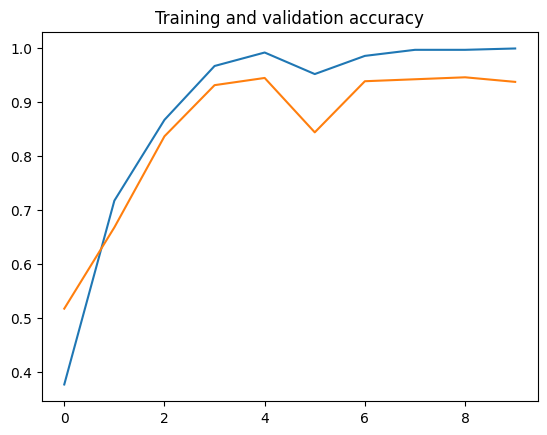

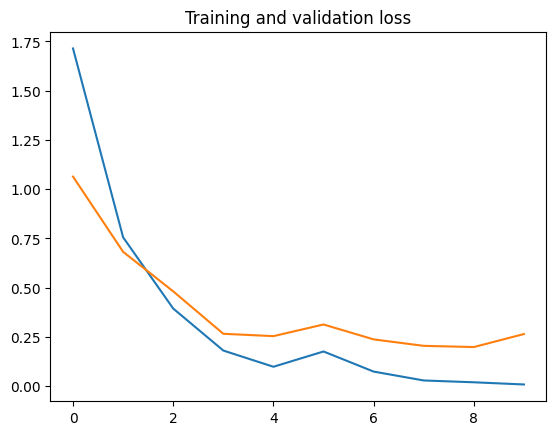

In [10]:
diagnostic_learning_curves()

In [11]:
prediction = model.predict(val_gen)
print(f"Prediction shape: {prediction.shape}")

42/42 [==============================] - 1s 15ms/step
Prediction shape: (825, 11)


In [14]:
model.evaluate(val_gen)

42/42 [==============================] - 1s 19ms/step - loss: 0.2647 - accuracy: 0.9370


[0.264698326587677, 0.9369696974754333]

In [12]:
y_pred = (prediction > 0.5).astype('int32')